# Temperature Variance in 2D Transient Stokes/Navier-Stokes Flow in Open/Close Channel

## Import packages

In [17]:
using Ferrite, SparseArrays, BlockArrays, LinearAlgebra, UnPack, LinearSolve, WriteVTK
using OrdinaryDiffEq
using FerriteGmsh
using FerriteGmsh: Gmsh
using Plots # added for simple plotting functionality 

## Section 1: Theoretical Foundation - Constant Density Flow with Temperature Effects

### Problem Description

In this notebook, we will solve the coupled flow and heat transfer problem for incompressible flow with constant density. This represents a simplification where we assume the density variations due to temperature are small enough to be neglected in the momentum equation.

**Computational Domain:** We consider a two-dimensional rectangular channel $(x,y) \in \Omega = (0,L) \times (0,H)$ where $L = 1 \, \text{m}$ and $H = 0.1 \, \text{m}$.

**Fields:**
- $\mathbf{u} = (u_x, u_y)^T$ is the velocity vector (units: m/s)
- $p$ is the kinematic pressure field (divided by density) (units: m²/s²)
- $T$ is the temperature field (units: K)
- $\rho$ is the (constant) density (units: kg/m³)

**Material Parameters:**
- $\mu$ is the dynamic viscosity (units: Pa·s = kg/(m·s))
- $\nu = \mu/\rho$ is the kinematic viscosity (units: m²/s)
- $c_p$ is the specific heat capacity at constant pressure (units: J/(kg·K))
- $k$ is the thermal conductivity (units: W/(m·K))
- $\alpha = k/(\rho c_p)$ is the thermal diffusivity (units: m²/s)

### Conservation of Mass (Continuity Equation)

For **constant density** flow, the conservation of mass simplifies to the incompressibility condition:

$$\nabla \cdot \mathbf{u} = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y} = 0 \quad \text{in } \Omega$$



### Conservation of Momentum (Navier-Stokes Equations)

For **constant density** flow, the momentum equation becomes:

$$\rho \frac{\partial \mathbf{u}}{\partial t} + \rho (\mathbf{u} \cdot \nabla) \mathbf{u} = -\rho\nabla p + \mu \nabla^2 \mathbf{u}  \quad \text{in } \Omega$$

where $\rho$ is the constant density.

### Conservation of Energy (Heat Transfer Equation)

The energy equation for temperature transport in a flowing fluid with constant density is:

$$\rho c_p \frac{\partial T}{\partial t} + \rho c_p (\mathbf{u} \cdot \nabla) T = k \nabla^2 T + \dot{Q} \quad \text{in } \Omega$$

Dividing by $\rho c_p$, we get:

$$\frac{\partial T}{\partial t} + (\mathbf{u} \cdot \nabla) T = \alpha \nabla^2 T + \frac{\dot{Q}}{\rho c_p} \quad \text{in } \Omega$$

where $\alpha = \frac{k}{\rho c_p}$ is the thermal diffusivity.

- The velocity field $\mathbf{u}$ from the momentum equation drives temperature transport
- This equation is similar to the scalar transport equation but with temperature-specific coefficients


### Equation of State (Ideal Gas Law)

For an ideal gas, the relationship between pressure, density, and temperature is given by:

$$p = \rho R_s T$$



For **constant density flow with temperature transport**, we solve the following system:

1. **Continuity (Mass Conservation):**
   $$\nabla \cdot \mathbf{u} = 0$$

2. **Momentum (Navier-Stokes):**
   $$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\nabla \left(\frac{p}{\rho}\right) + \nu \nabla^2 \mathbf{u}$$

3. **Energy (Heat Transfer):**
   $$\frac{\partial T}{\partial t} + (\mathbf{u} \cdot \nabla) T = \alpha \nabla^2 T + \frac{\dot{Q}}{\rho c_p}$$

4. **Equation of State:**
   $$p = \rho R_s T$$


## Section 2: Home-Brewed Post-Processing for Uniform Mesh 

In [18]:
function mypostprocess(u, dh)
 
    area = [] 
    velx = [] 
    vely = []
    velm = [] 
    pres = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:v)
        dof_range_p = dof_range(dh,:p)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        ploc = u[celldofs(dh,cell_num)[dof_range_p]]
        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        cellarea = 0. 
        cellvelocity = [0.,0.]
        cellpressure = 0 
    
        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            velocity = function_value(cellvalues_v, q_point, uloc)
            cellarea += dΩ 
            cellvelocity += velocity*dΩ
        end

        for q_point in 1:getnquadpoints(cellvalues_p)
            dΩ = getdetJdV(cellvalues_p, q_point)
            pressure = function_value(cellvalues_p, q_point, ploc)
            cellpressure += pressure*dΩ
        end

        append!(area, cellarea)
        append!(velx, cellvelocity[1]/cellarea) 
        append!(vely, cellvelocity[2]/cellarea)
        append!(velm, norm(cellvelocity)/cellarea)
        append!(pres, cellpressure/cellarea)
    
    end  

    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    velm2d = reshape(velm, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, velm2d, pres2d  
end 

function tracerpostprocess(u, dh, cellvalues_u1)
 
    area = [] 
    tracer = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_tracer = dof_range(dh,:u1)
        u1loc = u[celldofs(dh,cell_num)[dof_range_tracer]]
        Ferrite.reinit!(cellvalues_u1, cell)

        cellarea = 0. 
        celltracer = 0. 
    
        for q_point in 1:getnquadpoints(cellvalues_u1)
            dΩ = getdetJdV(cellvalues_u1, q_point)
            celltracercontrib = function_value(cellvalues_u1, q_point, u1loc)
            cellarea += dΩ
            celltracer += celltracercontrib*dΩ
        end

        append!(area, cellarea)
        append!(tracer, celltracer/cellarea)
    
    end  

    tracer2d = reshape(tracer, nels)
    
    return area, tracer2d  
end 

tracerpostprocess (generic function with 1 method)

## Section 3: 2D Mesh Generation 

In [19]:
#..geomettry parameters 
L = 1. 
H = 0.1
nels  = (40, 20) # number of elements in each spatial direction
left  = Vec((0., 0.))  # start point for geometry 
right = Vec((L, H,))   # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
#..mesh in x-direction and y-direction - intended for debugging 
xgrid = Vector(range(0, L, step=L/nels[1]))
ygrid = Vector(range(0, H, step=H/nels[2]))
#..lower left grid node - intended for pressure constraint. 
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 800 Quadrilateral cells and 861 nodes

## Section 4: Assembly of Stiffness and Mass Matrix

In [20]:
function assemble_mass_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end;

function assemble_stokes_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, ν, K::SparseMatrixCSC, dh::DofHandler)
    # Again, some buffers and helpers
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Kₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # Assembly loop
    stiffness_assembler = start_assemble(K)
    for cell in CellIterator(dh)
        # Don't forget to initialize everything
        fill!(Kₑ, 0)

        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)

            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, q_point, j)
                    Kₑ[BlockIndex((v▄, v▄), (i, j))] -= ν * ∇φᵢ ⊡ ∇φⱼ * dΩ
                end
            end

            for j in 1:n_basefuncs_p
                ψ = shape_value(cellvalues_p, q_point, j)
                for i in 1:n_basefuncs_v
                    divφ = shape_divergence(cellvalues_v, q_point, i)
                    Kₑ[BlockIndex((v▄, p▄), (i, j))] += (divφ * ψ) * dΩ
                    Kₑ[BlockIndex((p▄, v▄), (j, i))] += (ψ * divφ) * dΩ
                end
            end
        end

        # Assemble `Kₑ` into the Stokes matrix `K`.
        assemble!(stiffness_assembler, celldofs(cell), Kₑ)
    end
    return K
end;

## Section 5: Time integration

In [22]:
dim = 2 
degree = 2

ip_v = Lagrange{RefQuadrilateral, 2}()^dim
qr = QuadratureRule{RefQuadrilateral}(4)
cellvalues_v = CellValues(qr, ip_v);

ip_p = Lagrange{RefQuadrilateral, 1}()
cellvalues_p = CellValues(qr, ip_p);

dh = DofHandler(grid)
add!(dh, :v, ip_v)
add!(dh, :p, ip_p)
close!(dh);

ch = ConstraintHandler(dh);

# Ramp the inlet velocity 
vmax = 1.5 
vin(t) = min(t * vmax, vmax) #inflow velocity
parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(H - x[2])/H^2, 0.0))

# Case-(1/3)
if (true)
    # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:v, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    add!(ch, dbc1)

    # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        # getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:v, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 1)
    add!(ch, dbc3)
end 

∂Ω_free = getfacetset(grid, "right");

close!(ch)
update!(ch, 0.0);

viscosity = 1e0 # 1.0 / 1000.0; #dynamic viscosity
K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K, dh);

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

f = zeros(ndofs(dh));

In [23]:
T = 6.0
Δt₀ = 0.001
Δt_save = 0.1
ν = viscosity

K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, ν, K, dh);

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

u₀ = zeros(ndofs(dh))
apply!(u₀, ch);

jac_sparsity = sparse(K);

apply!(M, ch)

struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues_v::CellValues
    u::Vector
end
p = RHSparams(K, ch, dh, cellvalues_v, copy(u₀))

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

function navierstokes_rhs_element!(dvₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            dvₑ[j] -= v ⋅ ∇v' ⋅ φⱼ * dΩ
        end
    end
    return
end

function stokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

function navierstokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    # nonlinear contribution
    v_range = dof_range(dh, :v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    vₑ = zeros(n_basefuncs)
    duₑ = zeros(n_basefuncs)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]
        vₑ .= @views u[v_celldofs]
        fill!(duₑ, 0.0)
        navierstokes_rhs_element!(duₑ, vₑ, cellvalues_v)
        assemble!(du, v_celldofs, duₑ)
    end
    return
end;

function navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            for i in 1:n_basefuncs
                φᵢ = shape_value(cellvalues_v, q_point, i)
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                Jₑ[j, i] -= (φᵢ ⋅ ∇v' + v ⋅ ∇φᵢ') ⋅ φⱼ * dΩ
            end
        end
    end
    return
end

function stokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    return apply!(J, ch)
end;

function navierstokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    # Assemble variation of the nonlinear term
    n_basefuncs = getnbasefunctions(cellvalues_v)
    Jₑ = zeros(n_basefuncs, n_basefuncs)
    vₑ = zeros(n_basefuncs)
    v_range = dof_range(dh, :v)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]

        vₑ .= @views u[v_celldofs]
        fill!(Jₑ, 0.0)
        navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
        assemble!(assembler, v_celldofs, Jₑ)
    end

    return apply!(J, ch)
end;

st_rhs = ODEFunction(stokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
st_problem = ODEProblem(st_rhs, u₀, (0.0,T), p);

ns_rhs = ODEFunction(navierstokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
ns_problem = ODEProblem(ns_rhs, u₀, (0.0,T), p);

struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff=false, step_limiter! = ferrite_limiter!);

integrator = init(
    st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

pvd = paraview_collection("vortex-street")
for (step, (u,t)) in enumerate(intervals(integrator))
    VTKGridFile("vortex-street-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);

# Solving using the solve function

In [24]:
st_sol = solve(
    st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

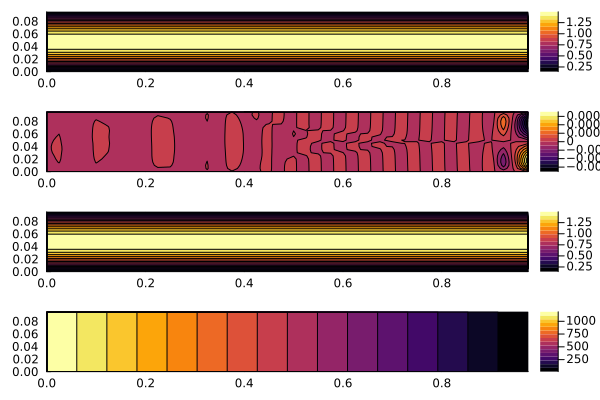

In [25]:
# post-process solution 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(st_sol.u[end], dh) 
p1 = contour(xgrid[1:end-1],ygrid[1:end-1],velx2d', fill=true)
p2 = contour(xgrid[1:end-1],ygrid[1:end-1],vely2d', fill=true)
p3 = contour(xgrid[1:end-1],ygrid[1:end-1],velm2d', fill=true)
p4 = contour(xgrid[1:end-1],ygrid[1:end-1],pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

## Section 6: Decoupled Temperature Transport (Post-Processing Approach)

### 1.2 No Coupling: Solve Transport Equation for Temperature in Post-Processing

**Approach:**
1. **First:** Solve the Navier-Stokes equations for velocity and pressure using a single DOF handler
2. **Second:** Use the computed velocity field to solve the temperature transport equation with a separate DOF handler
3. **No feedback:** Temperature doesn't affect the flow field (one-way coupling)

**Advantages:**
- Simpler implementation and debugging
- Lower computational cost per iteration
- Good reference solution for comparison with coupled approaches
- Suitable when temperature effects on flow are negligible

**Setup:**
- **DOF Handler 1:** Pressure-velocity field (as before)
- **DOF Handler 2:** Temperature field (separate, using same mesh)
- **Sequential solve:** Flow first, then temperature using flow as input

In [26]:
function assemble_temp_system!(K, dh_temp, cv_temp, dh_flow, cv_flow, flow_solution, α)
    """
    Assemble system matrix for the temperature transport equation (post-processing):
    (u⃗ · ∇)T = α ∇²T  (steady state, no heat source)
    
    This function assembles the convection-diffusion matrix for temperature transport
    using a pre-computed velocity field from the Navier-Stokes solution.
    
    Parameters:
    - K: Global system matrix for temperature (to be assembled)
    - dh_temp: DOF handler for temperature field (separate from flow)
    - cv_temp: Cell values for temperature field
    - dh_flow: DOF handler for flow field (velocity + pressure)
    - cv_flow: Cell values for velocity field
    - flow_solution: Solution vector from Navier-Stokes (contains velocity + pressure)
    - α: Thermal diffusivity [m²/s]
    """
    
    assembler = start_assemble(K)
    
    # Get DOF ranges
    range_temp = dof_range(dh_temp, :T)      # Temperature DOFs
    range_vel = dof_range(dh_flow, :v)       # Velocity DOFs from flow solution
    
    ndofs_temp = length(range_temp)
    Ke = zeros(ndofs_temp, ndofs_temp)
    
    # Shape function storage for temperature
    T_shape = Vector{Float64}(undef, ndofs_temp)
    ∇T_shape = Vector{Vec{2,Float64}}(undef, ndofs_temp)
    
    # Loop over all cells
    for (cell_num, cell) in enumerate(CellIterator(dh_temp))
        fill!(Ke, 0)
        
        # Reinitialize cell values for temperature field
        Ferrite.reinit!(cv_temp, cell)
        
        # Extract velocity DOFs for this cell from the flow solution
        vel_dofs_local = flow_solution[celldofs(dh_flow, cell_num)[range_vel]]
        
        # Loop over quadrature points
        for qp in 1:getnquadpoints(cv_temp)
            dΩ = getdetJdV(cv_temp, qp)
            
            # Get temperature shape functions and gradients
            for i in 1:ndofs_temp
                T_shape[i] = shape_value(cv_temp, qp, i)
                ∇T_shape[i] = shape_gradient(cv_temp, qp, i)
            end
            
            # Interpolate velocity at this quadrature point using flow cell values
            vel_qp = function_value(cv_flow, qp, vel_dofs_local)
            
            # Assemble element matrix
            for (i, I) in pairs(range_temp), (j, J) in pairs(range_temp)
                # Thermal diffusion term: α ∇T_i · ∇T_j
                diffusion_term = α * (∇T_shape[i] ⋅ ∇T_shape[j])
                
                # Thermal convection term: (u⃗ · ∇T_i) * T_j
                convection_term = (vel_qp ⋅ ∇T_shape[j]) * T_shape[i]
                
                
                # Add both terms to element matrix
                Ke[I, J] += (diffusion_term + 5*convection_term) * dΩ
            end
        end
        
        # Assemble element matrix into global matrix
        assemble!(assembler, celldofs(cell), Ke)
    end
    
    return K
end

assemble_temp_system! (generic function with 1 method)

In [27]:
function assemble_temp_system_art!(K, dh_temp, cv_temp, dh_flow, cv_flow, flow_solution, α)
    """
    Assemble system matrix for the temperature transport equation (post-processing):
    (u⃗ · ∇)T = α ∇²T  (steady state, no heat source)
    
    This function assembles the convection-diffusion matrix for temperature transport
    using a pre-computed velocity field from the Navier-Stokes solution.
    
    Parameters:
    - K: Global system matrix for temperature (to be assembled)
    - dh_temp: DOF handler for temperature field (separate from flow)
    - cv_temp: Cell values for temperature field
    - dh_flow: DOF handler for flow field (velocity + pressure)
    - cv_flow: Cell values for velocity field
    - flow_solution: Solution vector from Navier-Stokes (contains velocity + pressure)
    - α: Thermal diffusivity [m²/s]
    """
    
    assembler = start_assemble(K)
    
    # Get DOF ranges
    range_temp = dof_range(dh_temp, :T)      # Temperature DOFs
    range_vel = dof_range(dh_flow, :v)       # Velocity DOFs from flow solution
    
    ndofs_temp = length(range_temp)
    Ke = zeros(ndofs_temp, ndofs_temp)
    
    # Shape function storage for temperature
    T_shape = Vector{Float64}(undef, ndofs_temp)
    ∇T_shape = Vector{Vec{2,Float64}}(undef, ndofs_temp)
    
    # Loop over all cells
    for (cell_num, cell) in enumerate(CellIterator(dh_temp))
        fill!(Ke, 0)
        
        # Reinitialize cell values for temperature field
        Ferrite.reinit!(cv_temp, cell)
        
        # Extract velocity DOFs for this cell from the flow solution
        vel_dofs_local = flow_solution[celldofs(dh_flow, cell_num)[range_vel]]
        
        # Loop over quadrature points
        for qp in 1:getnquadpoints(cv_temp)
            dΩ = getdetJdV(cv_temp, qp)
            
            # Get temperature shape functions and gradients
            for i in 1:ndofs_temp
                T_shape[i] = shape_value(cv_temp, qp, i)
                ∇T_shape[i] = shape_gradient(cv_temp, qp, i)
            end
            
            # Interpolate velocity at this quadrature point using flow cell values
            # vel_qp = function_value(cv_flow, qp, vel_dofs_local)
            vel_qp = Vec((1.0, 0.0)) # artificial velocity field for debugging
            
            # Assemble element matrix
            for (i, I) in pairs(range_temp), (j, J) in pairs(range_temp)
                # Thermal diffusion term: α ∇T_i · ∇T_j
                diffusion_term = α * (∇T_shape[i] ⋅ ∇T_shape[j])
                
                # Thermal convection term: (u⃗ · ∇T_i) * T_j
                convection_term = (vel_qp ⋅ ∇T_shape[j]) * T_shape[i]
                # println(vel_qp)
                
                # Add both terms to element matrix
                Ke[I, J] += (diffusion_term + 5*convection_term) * dΩ
            end
        end
        
        # Assemble element matrix into global matrix
        assemble!(assembler, celldofs(cell), Ke)
    end
    
    return K
end

assemble_temp_system_art! (generic function with 1 method)

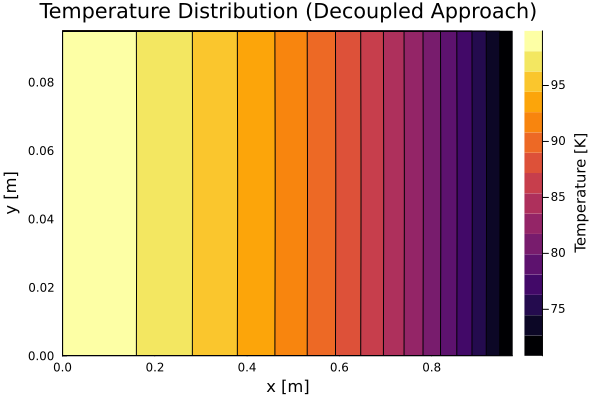


 Setting up separate DOF handler for temperature:

 Setting up temperature boundary conditions:

 Checking flow solution:
   ✓ Using time-dependent flow solution from Navier-Stokes

 Assembling temperature transport system:
   ✓ Temperature system matrix assembled
   ✓ Boundary conditions applied

 Solving temperature transport equation:


In [35]:
# =============================================================================
# DECOUPLED TEMPERATURE TRANSPORT IMPLEMENTATION
# =============================================================================

# 1. MATERIAL PROPERTIES FOR TEMPERATURE TRANSPORT

ρ = 1.0                    # Density [kg/m³]
cp = 1005.0                # Specific heat capacity [J/(kg·K)]
k_thermal = 2500          # Thermal conductivity [W/(m·K)]
α = k_thermal / (ρ * cp)   # Thermal diffusivity [m²/s]


# 2. SEPARATE DOF HANDLER FOR TEMPERATURE (Key requirement from supervisor)
println("\n Setting up separate DOF handler for temperature:")

# Temperature finite element setup
degree_temp = 2  # Same as velocity for consistency and accuracy
ip_temp = Lagrange{RefQuadrilateral, degree_temp}()

# Temperature cell values
qr_temp = QuadratureRule{RefQuadrilateral}(4)     
cv_temp = CellValues(qr_temp, ip_temp)

# SEPARATE DOF HANDLER for temperature 
dh_temp = DofHandler(grid)                    # Same mesh, different DOF handler
add!(dh_temp, :T, ip_temp)                   
close!(dh_temp)


# 3. TEMPERATURE BOUNDARY CONDITIONS
println("\n Setting up temperature boundary conditions:")

ch_temp = ConstraintHandler(dh_temp)

# Inlet temperature boundary condition
T_inlet = 100.0  # [K] Hot fluid at inlet
# T_walls = 70.0  # [K] Wall temperature (ambient)
T_outlet = 70.0

# Inlet BC: Hot fluid injection
dbc_inlet_temp = Dirichlet(:T, inlet, x -> T_inlet)
add!(ch_temp, dbc_inlet_temp)

# # Wall BC: Fixed temperature at walls (optional - can use natural BC instead)
# walls = union(getfacetset(grid, "top"), getfacetset(grid, "bottom"))
# dbc_wall_temp = Dirichlet(:T, walls, x -> T_walls)
# add!(ch_temp, dbc_wall_temp)

dbc_outlet_temp = Dirichlet(:T, ∂Ω_free, x -> T_outlet)
add!(ch_temp, dbc_outlet_temp)  


close!(ch_temp)

# println("   Inlet temperature: $T_inlet K")
# println("   Wall temperature: $T_walls K")

# 4. CHECK FLOW SOLUTION AVAILABILITY
println("\n Checking flow solution:")

if @isdefined(st_sol)
    println("   ✓ Using time-dependent flow solution from Navier-Stokes")
    u_flow = st_sol.u[end]  # Final time step
    # println("   ✓ Flow solution vector length: $(length(u_flow))")
else
    println("   ⚠ Time-dependent solution not available")
    println("   → Computing stationary Stokes solution for demonstration")
    
    # Solve stationary Stokes for temperature demonstration
    K_stokes = allocate_matrix(dh)
    K_stokes = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K_stokes, dh)
    f_stokes = zeros(ndofs(dh))
    
    t_stat = 1.0
    update!(ch, t_stat)
    apply!(K_stokes, f_stokes, ch)
    
    u_flow = K_stokes \ f_stokes
    println("   ✓ Stationary solution computed")
end

# 5. ASSEMBLE TEMPERATURE SYSTEM
println("\n Assembling temperature transport system:")

K_temp = allocate_matrix(dh_temp, ch_temp)
f_temp = zeros(ndofs(dh_temp))  # Zero RHS (no heat source)

# Assemble using the decoupled approach
assemble_temp_system!(K_temp, dh_temp, cv_temp, dh, cellvalues_v, u_flow, α)

println("   ✓ Temperature system matrix assembled")

# Apply boundary conditions
apply!(K_temp, f_temp, ch_temp)

println("   ✓ Boundary conditions applied")

# 6. SOLVE TEMPERATURE SYSTEM
println("\n Solving temperature transport equation:")

T_solution = K_temp \ f_temp


# Custom post-processing function for temperature
function temp_postprocess(T_sol, dh_temp, cv_temp)
    area = []
    temp_values = []
    
    for (cell_num, cell) in enumerate(CellIterator(dh_temp))
        dof_range_temp = dof_range(dh_temp, :T)
        T_local = T_sol[celldofs(dh_temp, cell_num)[dof_range_temp]]
        Ferrite.reinit!(cv_temp, cell)
        
        cell_area = 0.0
        cell_temp = 0.0
        
        for qp in 1:getnquadpoints(cv_temp)
            dΩ = getdetJdV(cv_temp, qp)
            temp_contrib = function_value(cv_temp, qp, T_local)
            cell_area += dΩ
            cell_temp += temp_contrib * dΩ
        end
        
        push!(area, cell_area)
        push!(temp_values, cell_temp / cell_area)
    end
    
    temp_2d = reshape(temp_values, nels)
    return area, temp_2d
end

# Process temperature solution
area_temp, temp2d = temp_postprocess(T_solution, dh_temp, cv_temp)


# Create visualization
plot_temp = contour(xgrid[1:end-1], ygrid[1:end-1], temp2d', 
                   fill=true, 
                   title="Temperature Distribution (Decoupled Approach)",
                   xlabel="x [m]", 
                   ylabel="y [m]",
                   colorbar_title="Temperature [K]")

display(plot_temp)

# plot velocity field as well


## Temperature variance in 1D channel flow

In 1D Energy equation for temperature transport in a flowing fluid with constant density is:
$$\rho c_p \frac{\partial T}{\partial t} + \rho c_p u \frac{\partial T}{\partial x} = k \frac{\partial^2 T}{\partial x^2} + \dot{Q} \quad \text{in } (0,L)$$

for steady state and no source term it reduces to:
$$ u \frac{\partial T}{\partial x} = \alpha \frac{\partial^2 T}{\partial x^2} \quad \text{in } (0,L)$$

rearranging gives:
$$ \frac{\partial^2 T}{\partial x^2} = \frac{u}{\alpha} \frac{\partial T}{\partial x} \quad \text{in } (0,L)$$

Defining a new variable, 
$$ v = \frac{\partial T}{\partial x}$$

The equation becomes:
$$ \frac{\partial v}{\partial x} = \frac{u}{\alpha} v \quad \text{in } (0,L)$$

Which had the analytical solution:
$$ T(x) = C_1  \frac{\alpha}{u} e^{\frac{u}{\alpha} x} + C_2$$

where $C_1$ and $C_2$ are constants determined by boundary conditions.

With T_in and T_out as boundary conditions, the solution becomes:
$$ T(x) = T_{in} + \frac{T_{out} - T_{in}}{e^{\frac{u}{\alpha} L} - 1} \left( e^{\frac{u}{\alpha} x} - 1 \right)$$

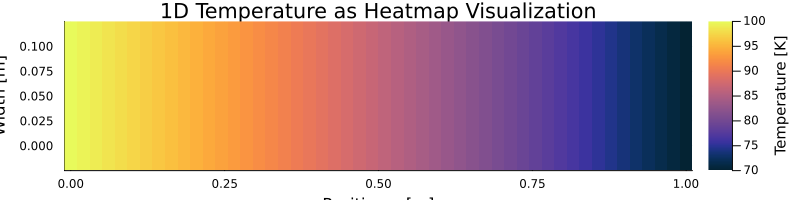

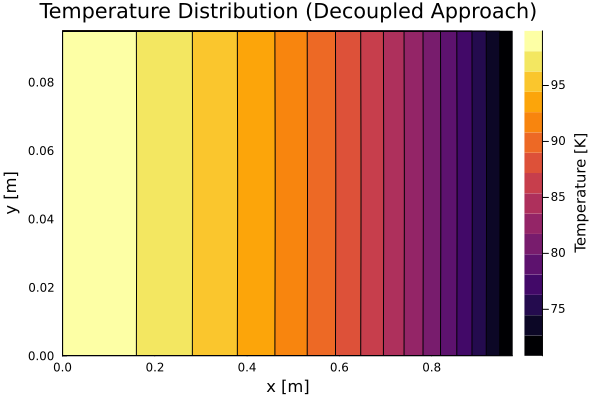

In [30]:
len = 1
u = 1
alpha = α

# plot the Solution
x = range(0, stop=len, length=50)
T = [T_inlet + (T_outlet - T_inlet) / (exp(u / alpha * len) - 1) * (exp(u / alpha * xi) - 1) for xi in x]

p = plot(x, T, xlabel="x [m]", ylabel="T [K]", title="1D Temperature Profile", legend=false)
plot(p, plot_temp, layout=(2,1))

y_fake = range(0.0, 0.1, length=3)  # Thin strip to show color gradient
T_2d = repeat(T', length(y_fake), 1)

p1d_heatmap = heatmap(x, y_fake, T_2d, 
                      aspect_ratio=:auto,
                      color=:thermal,
                      xlabel="Position x [m]",
                      ylabel="Width [m]", 
                      title="1D Temperature as Heatmap Visualization",
                      colorbar_title="Temperature [K]",
                      size=(800, 200))

display(p1d_heatmap)
display(plot_temp)

